In [1]:
%pip install plotly
import pandas as pd
from pandas import read_csv
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
# for mpl animation
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib import collections  as mc
import plotly.graph_objects as go
from scipy.stats import multivariate_normal
from copy import deepcopy
%matplotlib inline
rc('animation', html='html5')
games = read_csv('games.csv')
tracking_df = read_csv('tracking_week_1.csv')
play_df = read_csv('plays.csv')
players = read_csv('players.csv')
tackles = read_csv('tackles.csv')
tracking_data = tracking_df
plays = play_df
tracking_data['x'] = tracking_data.apply(lambda row : row['x'] if row['playDirection'] == 'right' else 120-row['x'], axis = 1)
tracking_data['y'] = tracking_data.apply(lambda row : row['y'] if row['playDirection'] == 'right' else 160/3-row['y'], axis = 1)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [92]:
import warnings
warnings.filterwarnings("ignore")

def get_board(gameId, playId, frameId):
    play = tracking_data[tracking_data['playId'] == playId][tracking_data['gameId'] == gameId][tracking_data['frameId'] == frameId]
    offenseTeam = plays[plays['playId'] == playId][plays['gameId'] == gameId]['possessionTeam'].values[0]
    defenseTeam = plays[plays['playId'] == playId][plays['gameId'] == gameId]['defensiveTeam'].values[0]
    offense = play[play['club'] == offenseTeam]
    defense = play[play['club'] == defenseTeam]

    carrierId, tacklerId = get_carrier_tackler(gameId, playId)
    offense_pos = get_player_position(gameId, playId, frameId, carrierId)
    defense_pos = get_player_position(gameId, playId, frameId, tacklerId)

    grid_offense = np.zeros((53, 120))
    for x, y in zip(offense['x'], offense['y']):
        if (y, x) != offense_pos and (y, x) != defense_pos:
            for offsetx in [-1, 0, 1]:
                for offsety in [-1, 0, 1]:
                    grid_offense[np.clip(int(y) + offsety, 0, 52), np.clip(int(x) + offsetx, 0, 119)] = 1

    grid_defense = np.zeros((53, 120))
    for x, y in zip(defense['x'], defense['y']):
        if (y, x) != offense_pos and (y, x) != defense_pos:
            for offsetx in [-1, 0, 1]:
                for offsety in [-1, 0, 1]:
                    grid_defense[np.clip(int(y) + offsety, 0, 52), np.clip(int(x) + offsetx, 0, 119)] = 1

    
    return np.array([offense['y'].values, offense['x'].values]).T, np.array([defense['y'].values, defense['x'].values]).T#grid_offense, grid_defense

def grid(values, pos, tol = 1.):
    for player_pos in values:
        if np.linalg.norm(player_pos - pos) < tol:
            return False
    return True
    
def get_carrier_tackler(gameId, playId):
    return plays[plays['playId'] == playId][plays['gameId'] == gameId]['ballCarrierId'].values[0], tackles[tackles['gameId'] == gameId][tackles['playId'] == playId]['nflId'].values[0]

def get_los(gameId, playId, ballCarrier):
    #playDirection = tracking_data[tracking_data['playId'] == playId][tracking_data['gameId'] == gameId]['playDirection'].values[0]
    #line_of_scrimmage = plays[plays['gameId'] == gameId][plays['playId'] == playId]['yardlineNumber'].values[0]
    #if playDirection == 'right':
    #    return line_of_scrimmage
    #return 100 - line_of_scrimmage
    
    return tracking_data[tracking_data['playId'] == playId][tracking_data['gameId'] == gameId][tracking_data['frameId'] == 1][tracking_data['nflId'] == ballCarrier]['x'].values[0]

    
def get_legal_moves(values, pos):
    legal_moves = []
    y = pos[0]
    x = pos[1]
    distances = np.linspace(1, 10, num = 3) / 6.
    angles = np.linspace(0, 2 * np.pi, num = 4)
    for distance in distances:
        for angle in angles:
            offsety = distance * math.sin(angle)
            offsetx = distance * math.cos(angle)
            newy = int(y + offsety)
            newx = int(x + offsetx)
            if 0 <= newy and newy < 53 and 0 <= newx and newx < 120:
                if grid(values, np.array([y + offsety, x + offsetx])):
                    legal_moves.append(np.array([y + offsety, x + offsetx]))
                    
    return legal_moves


def minimax(depth, grid_offense, grid_defense, offense_pos, defense_pos, max_or_min, alpha, beta, los, offense_cells, defense_cells, transpositions):
    if depth == 0 or np.linalg.norm(np.array(offense_pos) - np.array(defense_pos)) < 2:
        return offense_pos[1] - los, offense_cells, defense_cells
    best_score = -121.
    best_moves_offense = []
    best_moves_defense = []
    if str(grid_offense.round(decimals = 2)) + str(grid_defense.round(decimals = 2)) in transpositions:
        best_score, offense_moves, defense_moves, alpha, beta = transpositions[str(grid_offense.round(decimals = 2)) + str(grid_defense.round(decimals = 2))]
        return (best_score, offense_moves, defense_moves)
        
    if not max_or_min:#is minimizer, defense
        best_score = best_score * -1

        moves = get_legal_moves(grid_defense, np.array(defense_pos))
        if len(moves) == 0:
            return offense_pos[1] - los, offense_cells, defense_cells
        moves = sorted(moves, key = lambda x: np.linalg.norm(x - np.array(offense_pos)))
        for move in moves:
            new_defense_pos = move
            score, offensive_cells, defensive_cells = minimax(depth - 1, grid_offense, grid_defense, offense_pos, new_defense_pos, not max_or_min, alpha, beta, los, offense_cells, defense_cells + new_defense_pos.tolist(), transpositions)
            if score < best_score:
                best_score = score
                best_moves_offense = offensive_cells
                best_moves_defense = defensive_cells
            beta = min(beta, best_score)
            if beta <= alpha:
                transpositions[str(grid_offense.round(decimals = 2)) + str(grid_defense.round(decimals = 2))] = (best_score, best_moves_offense, best_moves_defense, alpha, beta)
                return best_score, best_moves_offense, best_moves_defense
                
    else:#is maximizer, offense
        moves = get_legal_moves(grid_offense, np.array(offense_pos))
        if len(moves) == 0:
            return offense_pos[1] - los, offense_cells, defense_cells
        
        #moves = sorted(moves, key = lambda x: -np.linalg.norm(x - np.array(defense_pos)))
        for move in moves:
            new_offense_pos = move
            score, offensive_cells, defensive_cells = minimax(depth - 1, grid_offense, grid_defense, new_offense_pos, defense_pos, not max_or_min, alpha, beta, los, offense_cells + new_offense_pos.tolist(), defense_cells, transpositions)
            if score > best_score:
                best_score = score
                best_moves_offense = offensive_cells
                best_moves_defense = defensive_cells
            alpha = max(alpha, best_score)

            if beta <= alpha:
                transpositions[str(grid_offense.round(decimals = 2)) + str(grid_defense.round(decimals = 2))] = (best_score, best_moves_offense, best_moves_defense, alpha, beta)
                return best_score, best_moves_offense, best_moves_defense
    return best_score, best_moves_offense, best_moves_defense

def get_player_position(gameId, playId, frameId, playerId):
    play = tracking_data[tracking_data['playId'] == playId][tracking_data['gameId'] == gameId][tracking_data['frameId'] == frameId]
    x = play[play['nflId'] == playerId]['x'].values[0]
    y = play[play['nflId'] == playerId]['y'].values[0]
    return y, x
gameId = 2022091100
playId = 1887
from time import time
from tqdm import tqdm
def get_evals(gameId, playId):
    num_frames = len(set(tracking_data[tracking_data['playId'] == playId][tracking_data['gameId'] == gameId]['frameId'].values))
    evals = []
    for i in tqdm(range(1, num_frames)):
        g_offense, g_defense = get_board(gameId, playId, i)
        #print(str(g_offense.round(decimals = 0)))
        import math
        carrierId, tacklerId = get_carrier_tackler(gameId, playId)
        offense_pos = get_player_position(gameId, playId, i, carrierId)
        defense_pos = get_player_position(gameId, playId, i, tacklerId)
        #start = time()
        yards, offense_cells, defense_cells = minimax(100, g_offense, g_defense, offense_pos, defense_pos, True, -math.inf, math.inf, get_los(gameId, playId, carrierId), [], [], {})
        evals.append(yards)
        #print('Yards gained ', i, ': ', yards, len(offense_cells) * .5 + len(defense_cells) * .5, ' Time: ', time() - start)
    return evals

def sign(x):
    if x < 0:
        return -1
    return 1
    
def get_keypoints(gameId, playId):
    evals = get_evals(gameId, playId)
    keyframes = []
    for i in range(1, len(evals) - 1):
        if sign(evals[i + 1] - evals[i]) != sign(evals[i] - evals[i - 1]):
            keyframes.append(i)
    return keyframes, evals

100%|███████████████████████████████████████████| 43/43 [00:11<00:00,  3.77it/s]


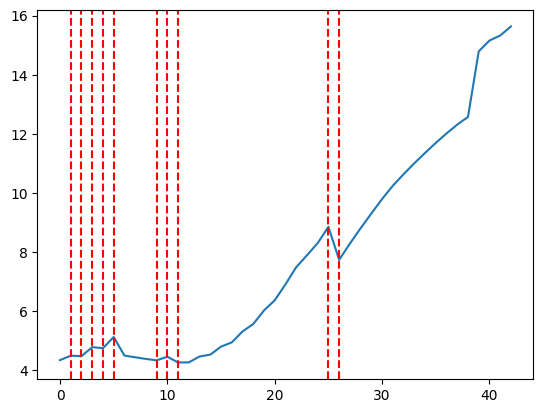

In [90]:
keyframes, evals = get_keypoints(2022091100, 1887)
plt.plot(evals)
for keyframe in keyframes:
    plt.axvline(keyframe, color = 'r', ls = '--')
plt.show()

100%|███████████████████████████████████████████| 53/53 [00:09<00:00,  5.61it/s]


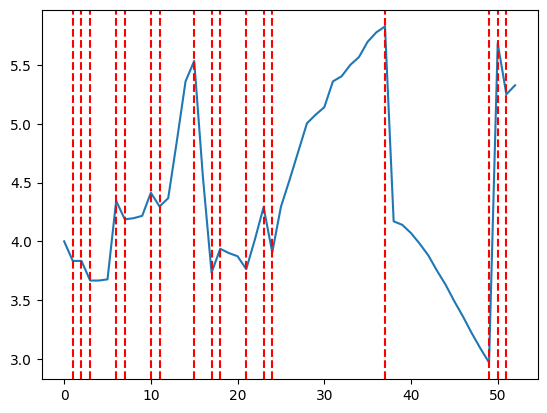

In [85]:
keyframes, evals = get_keypoints(2022091106, 1297)
plt.plot(evals)
for keyframe in keyframes:
    plt.axvline(keyframe, color = 'r', ls = '--')
plt.show()

100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.05it/s]


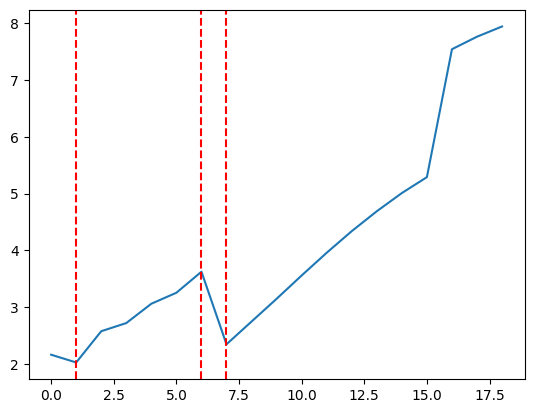

In [86]:
keyframes, evals = get_keypoints(2022091104, 58)
plt.plot(evals)
for keyframe in keyframes:
    plt.axvline(keyframe, color = 'r', ls = '--')
plt.show()

100%|███████████████████████████████████████████| 62/62 [00:10<00:00,  5.65it/s]


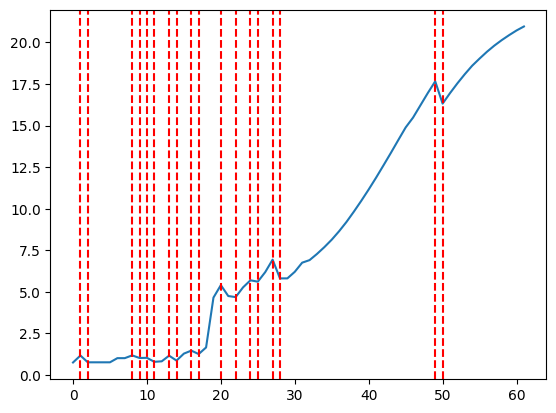

In [87]:
keyframes, evals = get_keypoints(2022091107, 3669)
plt.plot(evals)
for keyframe in keyframes:
    plt.axvline(keyframe, color = 'r', ls = '--')
plt.show()

100%|███████████████████████████████████████████| 63/63 [00:15<00:00,  4.03it/s]


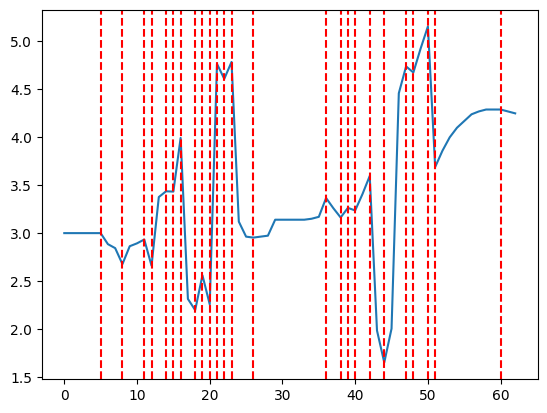

In [93]:
keyframes, evals = get_keypoints(2022091102, 3449)
plt.plot(evals)
for keyframe in keyframes:
    plt.axvline(keyframe, color = 'r', ls = '--')
plt.show()